In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.stats import mode
from tqdm.notebook import tqdm
from itertools import product
from multiprocessing import Pool

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df1 = pd.read_csv('../../finematching_result_phone1.csv', index_col=None)
df2 = pd.read_csv('../../finematching_result_phone2.csv', index_col=None)
df3 = pd.read_csv('../../finematching_result_phone3.csv', index_col=None)

In [3]:
df = pd.concat([df1, df2, df3])

In [2]:
df = pd.read_csv('../../finematching_result_new_phones123.csv', index_col=None)

In [4]:
#df = pd.read_csv('../../finematching_result_phone1.csv', index_col=None)
df = df.rename(columns={
    '0':'sample_actual',
    '1':'segmentation_algorithm',
    '2':'package_actual',
    '3':'phone',
    '4':'package_candidate',
    '5':'descriptor',
    '6':'kp_amount_actual',
    '7':'kp_amount_candidate',
    '8':'matches_amount',
    '9':'good_matches_amount',
    '10':'ransac_matches_amount',
})
df.head(10)
excluded_packages = ['0235_D01_S001', '0200_D01_S001', '0049_D01_S001', '0842_D01_S001', '0337_D01_S001', '0263_D01_S001', '0735_D01_S001', '0541_D01_S001', '0311_D01_S001']
df = df[~df.package_actual.isin(excluded_packages)]

In [5]:
df.sample(10)

,sample_actual,segmentation_algorithm,package_actual,phone,package_candidate,descriptor,kp_amount_actual,kp_amount_candidate,matches_amount,good_matches_amount,ransac_matches_amount
580935,Ph1_P0491_D02_S001_C3_az200,MSER,0491_D02_S001,2,0491_D01_S002,SIFT,2259.0,2293.0,2259.0,257.0,115.0
2260797,Ph3_P0189_D01_S001_C2_az280,MSER,0189_D01_S001,3,0836_D01_S001,SIFT,860.0,764.0,860.0,28.0,11.0
1512214,Ph2_P0424_D01_S001_C2_az240,MI1,0424_D01_S001,1,0580_D01_S001,SIFT,1657.0,3280.0,1657.0,68.0,15.0
920470,Ph1_P0812_D01_S001_C4_az160,MSER,0812_D01_S001,2,0812_D01_S001,SIFT,2632.0,2028.0,2632.0,462.0,359.0
2552913,Ph3_P0456_D01_S001_C2_az160,MSER,0456_D01_S001,1,0021_D01_S001,SIFT,734.0,1895.0,734.0,24.0,12.0
2008244,Ph2_P0888_D01_S001_C2_az080,MSER,0888_D01_S001,2,0133_D01_S001,SIFT,1243.0,1571.0,1243.0,88.0,22.0
814992,Ph1_P0711_D01_S001_C4_az020,MSER,0711_D01_S001,2,0202_D01_S001,SIFT,2676.0,2294.0,2676.0,142.0,39.0
1662543,Ph2_P0558_D01_S001_C1_az060,MSER,0558_D01_S001,1,0042_D01_S001,SIFT,981.0,3597.0,981.0,86.0,25.0
1275938,Ph2_P0213_D01_S001_C1_az320,MI1,0213_D01_S001,1,0670_D01_S001,SIFT,2299.0,1861.0,2299.0,51.0,16.0
2861730,Ph3_P0737_D01_S001_C3_az080,MSER,0737_D01_S001,1,0737_D01_S001,SIFT,812.0,1611.0,812.0,269.0,242.0


In [6]:
df = df[~df.ransac_matches_amount.isna()]

In [8]:
df['package_match'] = (df.package_actual == df.package_candidate)
df['ransac_kp_ratio'] = df.ransac_matches_amount / df.kp_amount_actual
df['ransac_matches_ratio'] = df.ransac_matches_amount / df.good_matches_amount
df['matches_kp_ratio'] = df.good_matches_amount / df.kp_amount_actual
df['kp_ratio'] = df.kp_amount_actual / df.kp_amount_candidate

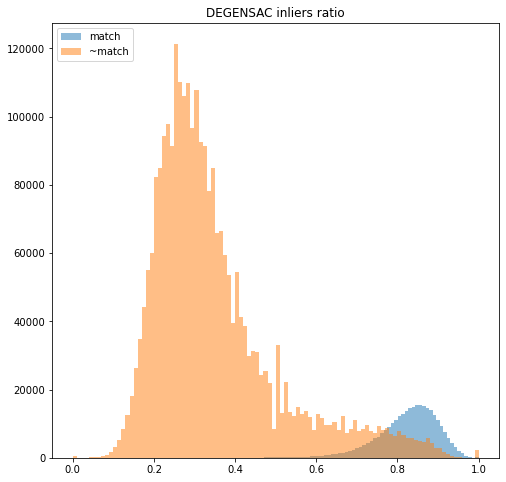

In [9]:
plt.figure(figsize=(8, 8))
s = plt.hist(df[df.package_match].ransac_matches_ratio, alpha=0.5, bins=100, label='match')
s = plt.hist(df[~df.package_match].ransac_matches_ratio, alpha=0.5, bins=100, label='~match')
plt.title('DEGENSAC inliers ratio')
plt.legend(loc='upper left')

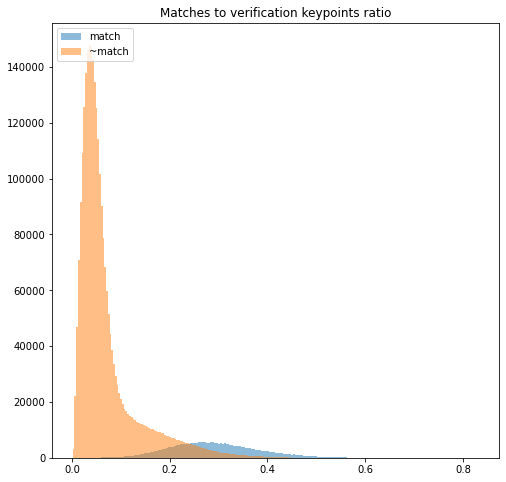

In [10]:
plt.figure(figsize=(8, 8))
s = plt.hist(df[df.package_match].matches_kp_ratio, alpha=0.5, bins=200, label='match')
s = plt.hist(df[~df.package_match].matches_kp_ratio, alpha=0.5, bins=200, label='~match')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Matches to verification keypoints ratio')
plt.legend(loc='upper left')

In [ ]:
plt.figure(figsize=(8, 8))
s = plt.hist(df[df.package_match].ransac_kp_ratio, alpha=0.5, bins=200, label='match')
s = plt.hist(df[~df.package_match].ransac_kp_ratio, alpha=0.5, bins=200, label='~match')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Inliers to verification keypoints ratio')
plt.legend(loc='upper left')

In [ ]:
(df[~df.package_match].matches_kp_ratio < df[df.package_match].matches_kp_ratio.min()).value_counts()

In [ ]:
list(product(df.segmentation_algorithm.unique(), df.descriptor.unique(), df.phone.unique()))

In [11]:
accuracies = {}
for algorithm, phone in product(df.segmentation_algorithm.unique(),df.phone.unique()):
    df_sub = df[(df.segmentation_algorithm == algorithm) & (df.phone == phone)]
    df_m = df_sub.loc[df_sub.groupby("sample_actual")["ransac_kp_ratio"].idxmax()]
    ac = df_m['package_match'].value_counts().to_dict()[True] / df_sub.sample_actual.nunique()
    print(algorithm, phone, ac)
    accuracies[(algorithm, phone)] = ac

MSER 1 0.925236424195563
MSER 2 0.9142443589641909
MSER 3 0.9164337120085648
MI1 1 0.947065934719277
MI1 2 0.9363481431572273
MI1 3 0.9383719086873811


In [ ]:
df_sub.shape

In [ ]:
df_s = df[(df.descriptor == 'SIFT') & (df.segmentation_algorithm == 'MI1')]
df_m = df_s.loc[df_s.groupby(["sample_actual", "segmentation_algorithm", 'descriptor'])["ransac_kp_ratio"].idxmax()]
df_p = df_m.pivot_table(index='sample_actual', columns='package_match', aggfunc='size', fill_value=0).reset_index()
df_p

In [ ]:
len(df_p[df_piv[True] > df_p[False]].index) / df_p.sample_actual.nunique()

In [ ]:
1 - df[df.package_match].sample_actual.nunique() / df.sample_actual.nunique()

In [ ]:
df_piv

In [ ]:
.shape

In [ ]:
total_samples_amount = df.sample_actual.nunique()

In [ ]:
df_sub = df[(df.segmentation_algorithm == 'MI1') & (df.descriptor == 'AKAZE')]

In [ ]:
1 - (df[(df.descriptor == 'SIFT') & (~df.ransac_matches_amount.isna())].sample_actual.nunique() / total_samples_amount)

In [ ]:
df[['sample_actual', 'package_actual', 'segmentation_algorithm', 'package_candidate', 'descriptor']].\
pivot_table(index=['sample_actual','package_actual'], columns=['segmentation_algorithm', 'descriptor'], values='package_candidate', aggfunc=lambda x: [s for s in x])

In [ ]:
df.package_candidate.nunique()

In [49]:
df_sub = df[(df.phone == 1) & (df.descriptor == 'SIFT')][['descriptor', 'sample_actual', 'package_actual', 'segmentation_algorithm', 'package_candidate', 'ransac_kp_ratio', 'ransac_matches_ratio', 'matches_kp_ratio']]
df_sub.sample(10)

,descriptor,sample_actual,package_actual,segmentation_algorithm,package_candidate,ransac_kp_ratio,ransac_matches_ratio,matches_kp_ratio
911220,SIFT,Ph1_P0795_D01_S001_C1_az340,0795_D01_S001,MI1,0099_D01_S001,0.017871,0.389831,0.045843
2577082,SIFT,Ph3_P0456_D01_S001_C2_az180,0456_D01_S001,MI1,0003_D02_S001,0.022727,0.750000,0.030303
1828541,SIFT,Ph2_P0698_D01_S001_C2_az340,0698_D01_S001,MSER,0238_D01_S003,0.020228,0.217877,0.092842
310101,SIFT,Ph1_P0248_D01_S001_C4_az200,0248_D01_S001,MI1,0265_D01_S001,0.003711,0.287129,0.012924
1960963,SIFT,Ph2_P0825_D01_S001_C2_az280,0825_D01_S001,MI1,0728_D01_S001,0.029412,0.346154,0.084967
681924,SIFT,Ph1_P0578_D01_S001_C2_az080,0578_D01_S001,MSER,0578_D01_S001,0.399160,0.866788,0.460504
2764015,SIFT,Ph3_P0620_D01_S001_C1_az320,0620_D01_S001,MI1,0531_D01_S001,0.009319,0.180556,0.051613
1857757,SIFT,Ph2_P0727_D01_S001_C2_az220,0727_D01_S001,MSER,0588_D01_S001,0.011609,0.358974,0.032338
1973484,SIFT,Ph2_P0837_D01_S001_C1_az040,0837_D01_S001,MI1,0083_D01_S001,0.008615,0.351351,0.024520
1979583,SIFT,Ph2_P0843_D01_S001_C2_az040,0843_D01_S001,MSER,0223_D02_S001,0.018182,0.180995,0.100455


In [25]:
dfs = [x for _, x in df[df.phone == 1].groupby('sample_actual')]

In [26]:
def calc_one(df):
    return df.pivot_table(
    index=['sample_actual', 'package_actual', 'package_candidate'],
    columns=['segmentation_algorithm'], # , 'descriptor'
).rank(
    method='max', na_option='bottom', ascending=False
).sum(axis=1).idxmin()

In [27]:
pool = Pool(processes=42)
res = pool.map(calc_one, dfs)
pool.close()

In [28]:
success = 0
fail = []
for r in res:
    if r[1][:-5] == r[2][:-5]:
        success += 1
    else:
        fail.append(r)
success / len(res)

0.9831797919762258

In [16]:
len(res)

50477

In [35]:
dfs[0].pivot_table(
    index=['sample_actual', 'package_actual', 'package_candidate'],
    columns=['phone', 'segmentation_algorithm', 'descriptor'],
).rank(
    method='max', na_option='bottom', ascending=False
).sum(axis=1).idxmin()

('Ph1_P0001_D01_S001_C4_az020', '0001_D01_S001', '0001_D01_S001')